In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gurobipy import *
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
import collections
import cvxpy as cp
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import scipy as sp

In [312]:
J = 2
d = 1
p = [1 / J] * J
N = 400

In [313]:
def worst_case(X, AX):
    m = Model('worst_case')
    m.setParam('LogToConsole', 0)
    
    beta = m.addVars((i for i in range(d+1)), vtype=GRB.CONTINUOUS)
    effect = m.addVars((k for k in range(len(X))), vtype=GRB.CONTINUOUS)
    
    m.setObjective(sum(effect[k] for k in range(len(X))), GRB.MINIMIZE)
    
    ## uncertainty
    m.addConstr(beta[0] >= beta_0_lb)
    m.addConstr(beta[0] <= beta_0_ub)    
    for i in range(d):
        m.addConstr(beta[i+1] >= beta_1_lb[i])
        m.addConstr(beta[i+1] <= beta_1_ub[i])
        
    ## ATE
    m.addConstr((beta[0] + sum(beta[i+1] * AX[i] for i in range(d))) >= ATE_lb)
    m.addConstr((beta[0] + sum(beta[i+1] * AX[i] for i in range(d))) <= ATE_ub) 
        
    ## assignment
    for k in range(len(X)):
        m.addConstr(effect[k] >= beta[0] + sum(beta[i+1] * X[k][i] for i in range(d)))  
        m.addConstr(effect[k] >= 0) 

    m.optimize()
    beta_ = m.getAttr('X', beta)
    
    return beta_

In [314]:
def best_case(X, AX):
    m = Model('worst_case')
    m.setParam('LogToConsole', 0)
    
    beta = m.addVars((i for i in range(d+1)), vtype=GRB.CONTINUOUS)
    effect = m.addVars((k for k in range(len(X))), vtype=GRB.CONTINUOUS)
    assign = m.addVars((k for k in range(len(X))), vtype=GRB.BINARY)
    
    m.setObjective(sum(effect[k] for k in range(len(X))), GRB.MAXIMIZE)
    
    ## uncertainty
    m.addConstr(beta[0] >= beta_0_lb)
    m.addConstr(beta[0] <= beta_0_ub)    
    for i in range(d):
        m.addConstr(beta[i+1] >= beta_1_lb[i])
        m.addConstr(beta[i+1] <= beta_1_ub[i])
        
    m.addConstr((beta[0] + sum(beta[i+1] * AX[i] for i in range(d))) >= ATE_lb)
    m.addConstr((beta[0] + sum(beta[i+1] * AX[i] for i in range(d))) <= ATE_ub) 
        
    ## assignment
    for k in range(len(X)):
        m.addConstr(effect[k] <= beta[0] + sum(beta[i+1] * X[k][i] for i in range(d)) + 2 * (1 - assign[k]))  
        m.addConstr(effect[k] <= 2 * assign[k]) 

    m.optimize()
    beta_ = m.getAttr('X', beta)
    
    return beta_

In [315]:
## linear regression
def linear_regress(Xs, Rs, method, sign=None):
    X_train, R_train = [], []
    for j in range(J):
        tmp = np.concatenate((Xs[j], np.zeros((len(Xs[j]), (d+1) * (J-1)))), axis=1)
        if j >= 1:
            for n in range(len(Rs[j])):
                tmp[n][d + (j-1) * (d+1)] = 1
                tmp[n][d + (j-1) * (d+1) + 1: d + j * (d+1)] = Xs[j][n]
        
        X_train.append(tmp)
        R_train.append(Rs[j])
    
    X_trains = np.concatenate(X_train)
    R_trains = np.concatenate(R_train)
      
    if method == 'ols':
        lr = linear_model.LinearRegression().fit(X_trains, R_trains)
        hat_beta_share_0, params = lr.intercept_, lr.coef_
    elif method == 'ridge':
        lr_ridge, obj_ridge = ridge(X_train, R_train) 
        hat_beta_share_0, params = lr_ridge.value[0], lr_ridge.value[1:]
    else:
        lr_positive, obj_positive = new(X_trains, R_trains, 1)  
        lr_negative, obj_negative = new(X_trains, R_trains, -1)

        min_loss = min(obj_positive, obj_negative)
        if obj_negative == min_loss:
            hat_beta_share_0, params = lr_negative.value[0], lr_negative.value[1:] 
        elif obj_positive == min_loss:
            hat_beta_share_0, params = lr_positive.value[0], lr_positive.value[1:] 
    
    hat_beta_share_1 = params[:d]
    hat_beta_0, hat_beta_1 = [], []
    for j in range(1, J):
        hat_beta_0.append(params[d + (j-1) * (d+1)])
        hat_beta_1.append(params[d + (j-1) * (d+1) + 1: d + j * (d+1)])
        
    R_hat = lr.predict(X_trains)
    residuals = R_trains - R_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares / (N - d)
    X_with_intercept = np.empty(shape=(N, (d+1)*J))
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:] = X_trains
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    std_beta_hat = []
    for i in range((d+1)*J):
        std_beta_hat.append(var_beta_hat[i, i] ** 0.5)
        
    return hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, std_beta_hat

In [316]:
def ridge(X_train, R_train): 
    K = 5
    X_fold = {0: np.split(X_train[0], K), 1: np.split(X_train[1], K)}
    R_fold = {0: np.split(R_train[0], K), 1: np.split(R_train[1], K)}
    
    coefs = [0, 0.02, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 20]
    coefs_loss = []
    
    for coef in coefs:  
        Loss = 0
        for k in range(K):
            R_valid = np.concatenate([R_fold[j][k] for j in range(J)])
            X_valid = np.concatenate([X_fold[j][k] for j in range(J)])

            R_input = np.concatenate([R_fold[j][l] for j in range(J) for l in range(K) if l != k])
            X_input = np.concatenate([X_fold[j][l] for j in range(J) for l in range(K) if l != k])

            beta, obj = ridge_opt(X_input, R_input, coef)
    
            loss = np.sum((np.dot(X_valid, beta.value[1:]) + beta.value[0] - R_valid) ** 2)
            Loss += loss
        coefs_loss.append(Loss / N)
    
    cv_coef = coefs[np.argmin(coefs_loss)]
    cv_loss = np.min(coefs_loss)
    print(cv_coef)
    X_trains = np.concatenate(X_train)
    R_trains = np.concatenate(R_train)
    beta, obj = ridge_opt(X_trains, R_trains, cv_coef)

    return beta, obj

In [317]:
def ridge_opt(X_train, R_train, coef):
    X_input, R_input = [], []
    for n in range(len(R_train)):
        X_input.append(np.concatenate(([1], X_train[n])))
        R_input.append(R_train[n])
        
    X_input = np.array(X_input)
    R_input = np.array(R_input)
    
    variable = cp.Variable((d + 1) * J)
  
    loss = cp.sum_squares(X_input @ variable - R_input) 

    regularizer = cp.sum_squares(variable[d+2:])

    prob = cp.Problem(cp.Minimize(loss + coef * regularizer))
    obj = prob.solve(verbose=False)
    
    return variable, obj    

In [318]:
def new(X_trains, R_trains, sign):
    X_input, R_input = [], []
    for n in range(N):
        X_input.append(np.concatenate(([1], X_trains[n])))
        R_input.append(R_trains[n])
        
    X_input = np.array(X_input)
    R_input = np.array(R_input)
    
    variable = cp.Variable((d + 1) * J)
  
    loss = cp.sum_squares(X_input @ variable - R_input) 
    
    agents = np.array(max_agents + min_agents)
    regularizer_mean = np.concatenate(([1], np.mean(agents, axis=0))) @ variable[d+1:]
    
    if len(agents) == 1:
        regularizer_var = 0
    else:
        cov_mat = np.cov(agents.T).reshape(d, d)
        regularizer_var = cp.quad_form(variable[d+2:], cov_mat)
    
    ATE_pred = np.concatenate(([1], AX)) @ variable[d+1:]

    if sign == 1:
        prob = cp.Problem(cp.Minimize(loss - len(max_agents + min_agents) * (0.01 * regularizer_mean - 0.2 * regularizer_var)), [regularizer_mean >= 0, ATE_pred <= ATE + 0.5 * ATE_std, ATE_pred >= ATE - 0.5 * ATE_std])
        obj = prob.solve(verbose=False)
        
    elif sign == -1:
        prob = cp.Problem(cp.Minimize(loss - len(max_agents + min_agents) * (-0.01 * regularizer_mean - 0.2 * regularizer_var)), [regularizer_mean <= 0, ATE_pred <= ATE + 0.5 * ATE_std, ATE_pred >= ATE - 0.5 * ATE_std])
        obj = prob.solve(verbose=False)
    
    return variable, obj

In [319]:
# generate coefficients
def generate_model():
    np.random.seed()
    beta_share_0 = np.random.normal(0, 0)
    beta_share_1 = np.random.normal(0, 0, size=d)

    beta_0 = np.random.normal(0.2, 0, size=J-1)
    beta_1 = np.random.normal(0.2, 0, size=(J-1, d))
    
    return beta_share_0, beta_share_1, beta_0, beta_1

In [320]:
# generate data
def generate_samples():
    Xs = []
    Rs = []
    for j in range(J):
        X1 = np.random.normal(-1.5, 0.5, size=(int(p[j] * N / 2), d))
        X2 = np.random.normal(-1.5, 0.5, size=(int(p[j] * N / 2), d))
        X = np.concatenate([X1, X2])
        
        #X[:, 1] = np.random.choice([-1, 1], size=int(p[j] * N), p=[0.5, 0.5])
        R = []
        for X_n in X:
            R_share = beta_share_0 + np.dot(X_n, beta_share_1)
            R_noise = np.random.normal(0, 0.2)
            if j == 0:
                R_treat = 0
            else:
                R_treat = beta_0[j-1] + np.dot(X_n, beta_1[j-1]) 

            R_n = R_share + R_noise + R_treat    
            R.append(R_n)

        Xs.append(X)
        Rs.append(np.array(R))
        
    X1 = np.random.normal(-1.5, 0.5, size=(5000, d))
    X2 = np.random.normal(-1.5, 0.5, size=(5000, d))
    Xt = np.concatenate([X1, X2])
    Rt = []

    #X[:, 1] = np.random.choice([-1, 1], size=int(p[j] * N), p=[0.5, 0.5])
    for X_n in Xt:
        R_share = beta_share_0 + np.dot(X_n, beta_share_1)
        R_noise = np.random.normal(0, 0.2)
        R = []
        for j in range(J):
            if j == 0:
                R_treat = 0
            else:
                R_treat = beta_0[j-1] + np.dot(X_n, beta_1[j-1]) 
            R_n = R_share + R_noise + R_treat 
            R.append(R_n)
        Rt.append(R)
        
    return Xs, Rs, Xt, Rt

In [321]:
# training
def prediction(Xs, Rs, method):
    hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, std_beta_hat = linear_regress(Xs, Rs, method)
    
    return hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, std_beta_hat

In [322]:
def policy(hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1):
    assigns = []
    predicts = []
    for j in range(J):
        for X_n in Xs[j]:
            effect_pred = hat_beta_0 + np.dot(hat_beta_1, X_n) 
            predicts.append(effect_pred)
            if effect_pred > 0:
                assigns.append(1)
            else:
                assigns.append(0)
     
    return assigns, predicts

def evaluate(hat_beta_0, hat_beta_1):
    reward = 0
    for n in range(len(Xt)):
        effect_pred = hat_beta_0 + np.dot(hat_beta_1, Xt[n]) 
        if effect_pred > 0:
            effect_true = beta_share_0 + np.dot(beta_share_1, Xt[n]) + beta_0 + np.dot(beta_1, Xt[n])
        else:
            effect_true = beta_share_0 + np.dot(beta_share_1, Xt[n])
        reward += effect_true.item()
        
    return reward

In [323]:
def resample(Xs, Rs, i):
    np.random.seed(i)
    Xs_boot, Rs_boot = [], []
    for j in range(J):
        size = len(Xs[j])
        idxs = np.random.choice(np.arange(size), size, p=[1/size]*size)
        Xs_boot.append(Xs[j][idxs])
        Rs_boot.append(Rs[j][idxs])
        
    return Xs_boot, Rs_boot

In [324]:
def bootstrap(Xs, Rs):
    res_assign, res_pred = [], []

    for i in range(1000):
        Xs_boot, Rs_boot = resample(Xs, Rs, i)
        hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1 = prediction(Xs_boot, Rs_boot, 'ols')
        assigns, predicts = policy(hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1)
        res_assign.append(assigns)
        res_pred.append(predicts)
        
    return res_assign, res_pred

In [325]:
# create sensitive set
def subseting():
    Covariates, Variances = [], []
    for n in range(N):
        if sum_of_assign[n] > 100 and sum_of_assign[n] < 900:
            Covariates.append(concat_Xs[n])
            Variances.append(var_of_pred[n])

    Covariates = np.array(Covariates)
    Variances = np.array(Variances)
    
    return Covariates, Variances

In [326]:
def decison_tree(m):
    # create a regressor object
    regressor = DecisionTreeRegressor(random_state = 0, max_leaf_nodes = m, max_depth = 3)

    # fit the regressor with X and Y data
    regressor.fit(Covariates, Variances)

    plt.figure(figsize=(10, 5), dpi=80)
    _ = plot_tree(regressor)

    leaves = regressor.apply(Covariates)
    
    return leaves

In [327]:
def bandwidth(tau):
    max_agents, min_agents = [], []
    for Xn in X:
        pred_effect = np.dot(hat_beta_1, Xn) + hat_beta_0
        if 0 <= pred_effect <= tau:
            max_agents.append(Xn)
        elif 0 >= pred_effect >= -tau:
            min_agents.append(Xn)
    
    return max_agents, min_agents

In [328]:
beta_share_0, beta_share_1, beta_0, beta_1 = generate_model()

In [329]:
ols_thres, reg_thres, ridge_thres, worst_thres, best_thres, final_thres = [], [], [], [], [], []
ols_rewards, reg_rewards, ridge_rewards, worst_rewards, best_rewards, final_rewards = [], [], [], [], [], []

for _ in range(100):
    print('----------')
    np.random.seed(_)
    Xs, Rs, Xt, Rt = generate_samples()
    ATE = np.mean(Rs[1]) - np.mean(Rs[0])
    ATE_std = np.sqrt((np.var(Rs[0]) * 2 + np.var(Rs[1]) * 2) / N)
    X = np.concatenate((Xs[0], Xs[1]))
    AX = np.mean(X, axis=0)
    
    # use ols to solve
    hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, std_beta_hat = prediction(Xs, Rs, 'ols')
    reward = evaluate(hat_beta_0, hat_beta_1)
    ols_rewards.append(reward)
    thre = [-(hat_beta_0[0] / hat_beta_1[0][i]) for i in range(d)]
    ols_thres.append(thre)   
    ATE_ols = (np.dot(hat_beta_1, AX) + hat_beta_0).item()
    #ATE_ols_std = 
    print(thre, 'as intercepts in ols')
    print(hat_beta_0, hat_beta_1, 'as coefficients in ols')
 
    CATE_std = np.sqrt(np.dot(np.dot(np.array(hat_beta_1), np.cov(X.T)), np.array(hat_beta_1).T)) * 1
    max_agents, min_agents = bandwidth(CATE_std)
    print(len(min_agents) + len(max_agents))
    
    if len(min_agents) + len(max_agents) > 5:
        local_ratio = 0.5 * (len(min_agents) + len(max_agents)) / N 
        print(ATE_ols, 'is ATE')
        ATE_lb, ATE_ub = ATE_ols - local_ratio * ATE_std, ATE_ols + local_ratio * ATE_std
        beta_0_lb, beta_0_ub = hat_beta_0 - local_ratio * std_beta_hat[d+1], hat_beta_0 + local_ratio * std_beta_hat[d+1]
        beta_1_lb, beta_1_ub = [], []
        for i in range(d):
            beta_1_lb.append(hat_beta_1[i] - local_ratio * std_beta_hat[d+i+2]) 
            beta_1_ub.append(hat_beta_1[i] + local_ratio * std_beta_hat[d+i+2])
        print(beta_0_lb, beta_0_ub, beta_1_lb, beta_1_ub)
        hat_beta = worst_case(X, AX)
        hat_beta_0, hat_beta_1 = hat_beta[0], np.array([hat_beta[i+1] for i in range(d)])
        print(hat_beta_0, hat_beta_1)
        worst_reward = evaluate(hat_beta_0, hat_beta_1)
        worst_rewards.append(worst_reward)
        worst_thre = []
        for i in range(d):
            if hat_beta_1[i] != 0:
                worst_thre.append(-1 * (hat_beta_0 / hat_beta_1[i]))
            else:
                worst_thre.append(0)
        print(worst_thre)
        worst_thres.append(worst_thre)
        
        assign_in_band = []
        for agent in min_agents + max_agents:
            if hat_beta_0 + np.dot(hat_beta_1, agent) > 0:
                assign_in_band.append(1)
            else:
                assign_in_band.append(0)
        worst_purity = np.mean(assign_in_band)
        print(worst_purity)
        
        hat_beta = best_case(X, AX)
        hat_beta_0, hat_beta_1 = hat_beta[0], np.array([hat_beta[i+1] for i in range(d)])
        print(hat_beta_0, hat_beta_1)
        best_reward = evaluate(hat_beta_0, hat_beta_1)
        best_rewards.append(best_reward)
        best_thre = []
        for i in range(d):
            if hat_beta_1[i] != 0:
                best_thre.append(-1 * (hat_beta_0 / hat_beta_1[i]))
            else:
                best_thre.append(0)
        print(best_thre)
        best_thres.append(best_thre)
        
        assign_in_band = []
        for agent in min_agents + max_agents:
            if hat_beta_0 + np.dot(hat_beta_1, agent) > 0:
                assign_in_band.append(1)
            else:
                assign_in_band.append(0)
        best_purity = np.mean(assign_in_band)
        print(best_purity)    
        
    else:
        worst_rewards.append(reward)
        best_rewards.append(reward)
    
    if sp.stats.entropy([best_purity, 1-best_purity]) < sp.stats.entropy([worst_purity, 1-worst_purity]):
        final_rewards.append(best_reward)
        print(best_thre)
    elif sp.stats.entropy([best_purity, 1-best_purity]) > sp.stats.entropy([worst_purity, 1-worst_purity]):
        final_rewards.append(worst_reward)
        print(worst_thre)
    else:
        final_rewards.append(reward)
        print(thre)
    
           
#         hat_beta_0, hat_beta_1 = hat_beta[0], np.array([hat_beta[i+1] for i in range(d)])
#         worst_reward = evaluate(hat_beta_0, hat_beta_1)
#         worst_rewards.append(worst_reward)
#         worst_thre = [-(hat_beta[0] / hat_beta[i+1]) for i in range(d)]
#         print(worst_thre)
#         worst_thres.append(worst_thre) 
    
#     # use ridge to solve
#     hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1 = prediction(Xs, Rs, 'ridge')
#     ridge_reward = evaluate(hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1)
#     ridge_rewards.append(ridge_reward)
#     ridge_thre = [-(hat_beta_0[0] / hat_beta_1[0][i]) for i in range(d)]
#     ridge_thres.append(ridge_thre) 
#     print(ridge_thre, 'as intercepts in ridge')
#     print(hat_beta_0, hat_beta_1, 'as coefficients in ridge')
    
#     # bootstrap
#     res_assign, res_pred = bootstrap(Xs, Rs)
    
#     sum_of_assign = np.sum(res_assign, axis=0)
#     var_of_pred = np.var(res_pred, axis=0).reshape(-1)
#     Covariates, Variances = subseting()
    

#     if max_agents != []:
#         print(max(max_agents))
        
#     if min_agents != []:
#         print(min(min_agents))
    
#     if len(min_agents + max_agents) > 0:
#         hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1 = prediction(Xs, Rs, 'reg')
#     else:
#         hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1 = prediction(Xs, Rs, 'ols')
#     reg_reward = evaluate(hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1)
#     reg_rewards.append(reg_reward)
#     reg_thre = [-(hat_beta_0[0] / hat_beta_1[0][i]) for i in range(d)]
#     reg_thres.append(reg_thre)
    
#     print(reg_thre, 'as intercepts in reg')
#     print(hat_beta_0, hat_beta_1, 'as coefficients in reg')

----------
[-0.8601643567299331] as intercepts in ols
[0.13457387955252934] [array([0.15645136])] as coefficients in ols
159
-0.10154395742043956 is ATE
[0.12274923] [0.14639853] [array([0.1490345])] [array([0.16386821])]
0.12274922661693183 [0.15128979]
[-0.8113517119345356]
0.20754716981132076
0.14639853248812687 [0.16161293]
[-0.9058590594087218]
0.27672955974842767
[-0.8113517119345356]
----------
[-1.0462456020781015] as intercepts in ols
[0.270582049501499] [array([0.25862192])] as coefficients in ols
216
-0.1043125749811174 is ATE
[0.25330873] [0.28785537] [array([0.24731698])] [array([0.26992686])]
0.2533087259255758 [0.25081227]
[-1.0099534833507555]
0.3148148148148148
0.2878553730774222 [0.26643158]
[-1.08041012879174]
0.37962962962962965
[-1.0099534833507555]
----------
[-1.0486378647465857] as intercepts in ols
[0.27533104895347327] [array([0.26256066])] as coefficients in ols
191
-0.12846225133457828 is ATE
[0.26050832] [0.29015378] [array([0.25344685])] [array([0.27167447

In [330]:
np.round(np.mean(ols_rewards) / len(Xt), 8),  np.round(np.mean(worst_rewards) / len(Xt), 8), np.round(np.mean(best_rewards) / len(Xt), 8), np.round(np.mean(final_rewards) / len(Xt), 8)

(0.00763023, 0.0077006, 0.00739606, 0.0077006)

(array([[ 1.,  0.,  0.,  0.,  1.,  2.,  4.,  1.,  5.,  6., 14., 11., 15.,
         14.,  4.,  8.,  5.,  3.,  4.,  2.],
        [ 0.,  1.,  0.,  0.,  0.,  1.,  2.,  4.,  1.,  4.,  8., 14., 13.,
         18.,  8., 10.,  5.,  4.,  5.,  2.]]),
 array([-1.61933403, -1.56977503, -1.52021602, -1.47065702, -1.42109801,
        -1.37153901, -1.32198   , -1.272421  , -1.22286199, -1.17330299,
        -1.12374398, -1.07418498, -1.02462597, -0.97506697, -0.92550796,
        -0.87594896, -0.82638995, -0.77683095, -0.72727194, -0.67771294,
        -0.62815393]),
 <a list of 2 BarContainer objects>)

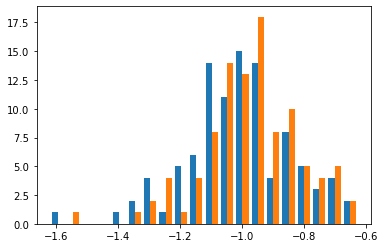

In [309]:
plt.hist([np.array(ols_thres).reshape(-1), np.array(worst_thres).reshape(-1)], bins=20)

In [563]:
# plt.figure(figsize=(10, 10), dpi=80)

# for ols_thre in ols_thres:
#     k = -1 * (ols_thre[1] / ols_thre[0])
#     b = ols_thre[1]
#     x = np.arange(-2, 2, 0.5)
#     y = k * x + b
#     plt.plot(x, y, c='blue', lw=0.3)
    
# for reg_thre in reg_thres:
#     k = -1 * (reg_thre[1] / reg_thre[0])
#     b = reg_thre[1]
#     x = np.arange(-2, 2, 0.5)
#     y = k * x + b
#     plt.plot(x, y, c='red', lw=0.3)
    
# for j in range(J):
#     plt.scatter(Xs[j][:,0], Xs[j][:,1], c='black', s=0.5)